# Lista de Exercícios \#5
## Breno Vieira Arosa

In [1]:
import numpy as np
import pandas as pd
from scipy import stats

from functools import partial

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

In [2]:
plt.rcParams.update({'font.size': 14})

## Questão 1

In [3]:
def ackley(x):
    a = np.sqrt((x**2).mean(axis=1))
    b = (np.cos(2 * np.pi * x)).mean(axis=1)
    
    return -20 * np.exp(-.2 * a) - np.exp(b) + 20 + np.e

In [4]:
class EP(object):
    
    def __init__(self, individual_dimension, population_size, fitness_func):
        self.population_size = population_size
        self.individual_dimension = individual_dimension
        self.fitness_func = fitness_func
        
        self.population = self.init_population()
    
    
    def init_population(self):
        """
        Initialize population.
        """
        
        population = pd.DataFrame()
        
        #x0 = np.random.normal(loc=0, scale=1, size=(self.population_size, self.individual_dimension))
        x0 = np.random.uniform(low=-30, high=30, size=(self.population_size, self.individual_dimension))
        sigma0 = 6 * np.ones((self.population_size, self.individual_dimension))
        return {"x": x0, "sigma": sigma0}
    
    
    def evaluate(self, x):
        return -self.fitness_func(x)
    
    
    def mutate(self, population, alfa=.2, sigma_eps=0.03):
        """
        Gaussian Mutation - sigma first.
        """
        
        n = population["x"].shape[0]
        
        # one gaussian variable per individual
        sigma = population["sigma"] * np.random.normal(loc=1, scale=alfa, size=n).reshape(-1, 1)
        sigma[sigma < sigma_eps] = sigma_eps
        
        x = population["x"] + np.random.normal(loc=0, scale=sigma, size=(n, self.individual_dimension))

        
        return {"x": x, "sigma": sigma}

    
    def natural_selection(self, parents, offspring, q=10):
        """
        Tournament Competition.
        """
        
        # union parents and offspring
        population = {}
        population["x"] = np.vstack((parents["x"], offspring["x"]))
        population["sigma"] = np.vstack((parents["sigma"], offspring["sigma"]))
        
        # caches all fitness values
        fitness = self.evaluate(population["x"])
        tournament_scores = pd.DataFrame({"fitness": fitness, "wins": None})
        
        n = population["x"].shape[0]
        
        for i in range(n):
            # select opponents without selecting itself
            possible_opponents = tournament_scores.index[tournament_scores.index != i]
            opponents =  np.random.choice(possible_opponents, replace=False, size=q)
            
            # count how many wins individual have in its group
            tournament_scores.loc[i, "wins"] = (tournament_scores.loc[i, "fitness"] > tournament_scores.loc[opponents, "fitness"]).sum()
        
        most_wins = tournament_scores.nlargest(self.population_size, "wins", keep="last")
        
        x = population["x"][most_wins.index]
        sigma = population["sigma"][most_wins.index]
        
        return {"x": x, "sigma": sigma}

    
    def evolve(self):
        offspring = self.mutate(self.population)
        self.population = self.natural_selection(self.population, offspring)
        return

In [5]:
ep = EP(30, 100, ackley)

In [6]:
N = 500

history = np.zeros((N, ep.population_size, ep.individual_dimension))
for i in range(N):
    history[i, :, :] = ep.population["x"].copy()
    ep.evolve()

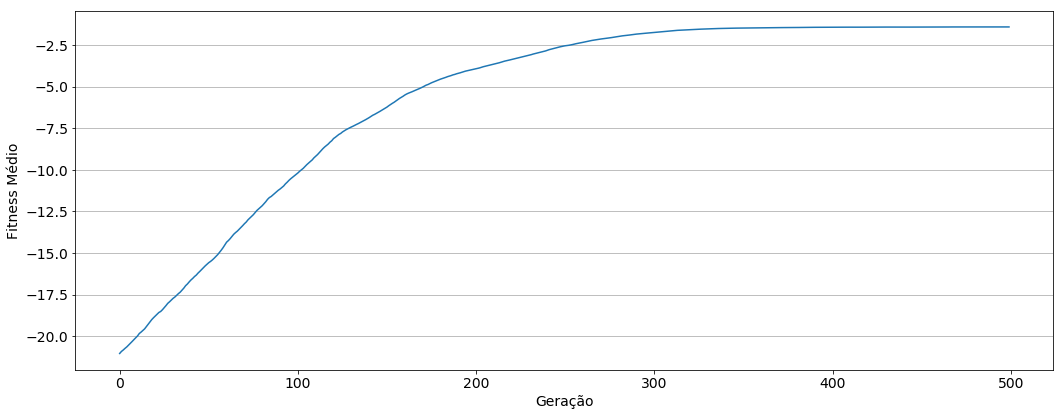

In [7]:
history_mean = np.zeros((N))
history_min = np.zeros((N))
history_max = np.zeros((N))
for i in range(N):
    fitness = ep.evaluate(history[i, :, :])
    fitness.std()
    history_mean[i] = fitness.mean()
    history_min[i] = fitness.min()
    history_max[i] = fitness.max()

plt.figure(figsize=(15, 6))

#plt.fill_between(np.linspace(0, N-1, N), history_min, history_max, alpha=.2)
plt.plot(np.linspace(0, N-1, N), history_mean)

plt.ylabel("Fitness Médio")
plt.xlabel("Geração")
plt.grid(axis="y")
plt.tight_layout()
plt.show()

## Questão 2
### Consider using the number of generations as a measure to establish the speed of an EA. Compare the use of this measure with using the number of fitness evaluations.

O uso de gerações para avaliar a velocidade dos algoritmos evolucionarios não é uma medida confiavél.
Isto acontece porque diferentes fatores podem afetar o tempo de execução.
Por exemplo, o número de indivíduos, a escolha do algoritmo de seleção de pais, entre outros.
Em geral, a availação da função fitness é a parte computacionalmente mais custosa do algoritmo, portanto, o número de avaliações da função fitness se torna uma boa métrica de velocidade para os algoritmos evolucionarios.

## Questão 3

### Give the arguments why mutation strength (e.g., pm or sigma) should be increased during a run. Give arguments why it should be decreased

Existem dois conceitos importantes para algoritmos de otimização: "exploitation" e "exploration".
"Exploration" representa a capacidade do algoritmo de explorar diferentes regiões e/ou soluções de um problema.
Enquanto "exploitation" é a concentração das buscas nas regiões de bons resultados conhecidos.

Geralmente, a etapa de mutação tem como objetivo aumentar o "exploration", forçando o algoritmo a buscar novas soluções.
Porém, variações como Programação Evolucionária dependem apenas das mutações para evolução, ficando estas responsáveis também para fase de "exploitation".

Portanto, o uso de fortes mutações, tanto por pm quanto por sigma, é indicado na fase exploratória do algoritmo.
Essa fase normalmente ocupa o início das execuções mas também pode ser utilizada quando se convergir a algum mínimo.
A fase de exploração pode ser mais eficientes utilizando baixos valores de mutação.
Sendo assim, é interessante se começar o algoritmo com altos valores de mutação e ir decrescendo esses índices a medida que se busca refinar a região de mínimo encontrada.

## Questão 4

A utilização de algoritmos genéticos para clusterização pode ser feita de duas formas:  
- Representando os dados por um vetor de números inteiros em que cada número corresponde ao clusters correspondente.
- Definindo uma matriz de codebook Y na qual cada linha representa o ponto central de cada cluster.

Nessa questão consideraremos a solução referente ao segundo caso.  
Para tal, teremos uma matriz X em que cada linha representa um exemplo do conjunto de dados.  
Será inicializada a matriz de codebook Y de forma aleatória.  
A matriz Y será otimizada pelo algoritmo genético simples de maneira a minimizar a função custo apresentada no problema.  

O algoritmo genético simples será composto pelos seguintes blocos:  

**Representação:** Como a matriz de codebook representa o pontos centrais dos clusters, está será uma matriz de valores reais de mesma dimensão que a dos dados X.  
**Mutação:** A mutação de dados reais pode ser feita substituindo um dos genes de cada indivíduo por um valor sorteado dentro do domínio do problema.  
**Recombinação:** É possivel realizar a recombinação aritimética completa na qual dado um par de indivíduos pais geram-se dois indivíduos igual que são a média entre pais selecionados.  
**Selecao de pais:** Podemos aplicar a seleção por ranking linear na qual os pais tem probabilidade de sorteio definidas pelo seu fitness. Além disso, o parâmetro "s" controla a proporção dessas probabilidades.  
**Selecao de sobreviventes:** A seleção de sobreviventes pode ser feita por torneio, pode-se utilizar também o mecanismo de elitismo. No torneio, para cada indivíduo serão selecionados "q" competidores e serão contados o número de vitórias de cada indivíduo em seus torneios. Os indivíduos com maior número de vitórias serão selecionados.